# Proportion of nonsynonymous to synonymous mutations (pNS) in serial isolates from patients

## APPROACH:
In the past I've done this both over time as well as collating data for the two sets of patients. There is insufficient data to glean any information from time-based approaches, so I will focus only on combined data.

Possible sources of null distributions: 
- simulations based on specific base substitution models,
- annotations of sub 1.5% alleles,
- annotations of error-rate dataset used for vSNP frequency cutoff estimations.

The pNS calculations need a substitution matrix to derive the expected outcomes of mutagenesis under the assumption of neutrality. There are several <a href='https://en.wikipedia.org/wiki/Models_of_DNA_evolution'>nucleotide substitution models</a> that have been described, however all of them were designed to be used for evolutionary inference and therefore allow for the possibility of no mutation. If I am actually simulating the outcome of mutation this is not particularly useful. 

I can think of two approaches:
1. treat the whole thing as a Markov model with the probability of no change fixed to 0. The remaining transition probabilities can then be estimated from data. 
2. Start from the Hasegawa, Kishino & Yano model [J Mol Evol (1985), <strong>22:</strong> <em>160-174</em>], which tries to control the output of the mutagenesis to mantain the genomic status quo. To do this it leverages observed base frequencies within the genome and accounts for the difference in the probability of transitions and transversions in biological systems.

The next steps are then to:

1. Calculate the base distribution for the CCDC5079 genome.
2. Catalog <a href='https://en.wikipedia.org/wiki/Codon_degeneracy'>fourfold degenerate positions within codons</a> affected by fSNPs,
3. Use FFD to empiricaly derive the transition probabilities for each possible mutation ($\pi_{ij}$)

$Q = \left(
\begin{array}{cccc}
0 & \lambda_{TC} & \lambda_{TA} & \lambda_{TG} & \\
\lambda_{CT} & 0 & \lambda_{CA} & \lambda_{CG} & \\
\lambda_{AT} & \lambda_{AC} & 0 & \lambda_{AG} & \\
\lambda_{GT} & \lambda_{GC} & \lambda_{GA} & 0 & \\
\end{array} \right)$

After this we can use base frequencies and the probability of transition/transversion mutations to generate a more generic version of this idea (approach 2 above). In this iteration $\alpha$=Pr(transition) correcponds to its respective substitution. While $\beta$=Pr(transversion) and is weighed by the frequency of the target base as a proportion of its base type. $\pi_T$, $\pi_C$, $\pi_A$, $\pi_G$ are derived empirically and $\pi_R=\pi_A+\pi_G$, $\pi_Y=\pi_C+\pi_T$. The scaling with $\pi_Y$ and $pi_R$ is only there to make sure that the probability of mutation summs up to 1.

$Q = \left(
\begin{array}{cccc}
0 & \alpha & \beta\frac{\pi_A}{\pi_R} & \beta\frac{\pi_G}{\pi_R} & \\
\alpha & 0 & \beta\frac{\pi_A}{\pi_R} & \beta\frac{\pi_G}{\pi_R} & \\
\beta\frac{\pi_T}{\pi_Y} & \beta\frac{\pi_C}{\pi_Y} & 0 & \alpha & \\
\beta\frac{\pi_T}{\pi_Y} & \beta\frac{\pi_C}{\pi_Y} & \alpha & 0 & \\
\end{array} \right)$

Once we've obtained these, we can:
5. Use simulations to derive codon substitution matrices.
6. Calculate the pNS using the codon substitution matrix for each timepoint for each sample. For vSNP and fSNP separately.
7. Derive null distributions for each sample using one of the options above.

## ANALYSIS
Start by setting up the environment.

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")
import random

#Additional Python packages
import tqdm

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

mpl.style.use('classic')
mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [2]:
#FIGURE DETAILS
tick_size = 8
label_size = 10
title_size = 10
text_size = 8
single_column_figure = (3.35,3.35)
double_column_figure_r = (6.69,5)
double_column_figure_s = (6.69,6.69)

### GC content

In [2]:
#Get CCDC5079 genome sequence
REFERENCE_PATH = '../data/external/'
CCDC5079_GENOME = ''.join([line.strip() for line in open('{}NC_021251.fa'.format(REFERENCE_PATH)) if line[0]!='>'])

Once we have the genome, we can calcualte the percentage of GC within it.

In [3]:
CCDC5079_counts = Counter(CCDC5079_GENOME)
CCDC5079_size = len(CCDC5079_GENOME)

pi_a = CCDC5079_counts['A']/CCDC5079_size
pi_c = CCDC5079_counts['C']/CCDC5079_size
pi_g = CCDC5079_counts['G']/CCDC5079_size
pi_t = CCDC5079_counts['T']/CCDC5079_size

print('%A: {0:0.1f}, %C: {1:0.1f}, %G: {2:0.1f}, %T: {3:0.1f}'.format(pi_a*100, pi_c*100, pi_g*100, pi_t*100))

%A: 17.2, %C: 32.9, %G: 32.7, %T: 17.2


Looks like $\pi_T\approx\pi_A$ and $\pi_C\approx\pi_G$. Is this universal (quickly checked <em>E. coli</em> and <em>M. smegmatis</em> and it seems to be true for both of them. Question for another day though...

### Transition probability
Use the four-fold degenerate positions for fixed substitutions.

We have annotated all fixed mutations found in our patients, the annotation file is stored as a pickle:

In [4]:
#LOAD FIXED MUTATIONS
INTERIM_PATH = '../data/interim/'
FIXED_ANNOTATION_DICT = pickle.load(open('{}2_fixed_annotation.pkl'.format(INTERIM_PATH),'rb'))

for k,v in FIXED_ANNOTATION_DICT.items():
    pass

print(k,v)

2060037 [['CFBS09570-CFBS09575', 'IGR', '-', '---', '..260-132..', 1]]


The key stands for the LOCUS, and values contain a list of annotations that occured for SNPs at that locus. If the same locus is mutated in multiple strains there will be several entries. The items in the value list are also lists with the following content:

- [0] LOCUS_ID (CCDC5079 nomenclature)
- [1] SNP type
- [2] Mutated residue
- [3] Amino acid change if applicable
- [4] Codon change if applicable
- [5] Mutation type: Transition (1) / Transversion (0)

Now we need to iterate through the dictionary to find synonymous mutations, and keep only FFD dinucleotides.

In [5]:
FFD_dict = {'AC': {'Ti': 0, 'Tv': 0},
            'CT': {'Ti': 0, 'Tv': 0},
            'CC': {'Ti': 0, 'Tv': 0},
            'CG': {'Ti': 0, 'Tv': 0},
            'GC': {'Ti': 0, 'Tv': 0},
            'GG': {'Ti': 0, 'Tv': 0},
            'GT': {'Ti': 0, 'Tv': 0},
            'TC': {'Ti': 0, 'Tv': 0},
            'TOTAL': 0,
            'Ti': 0,
            'Tv': 0
            }

MUTATION_TYPE = {0: 'Tv', 1: 'Ti'}

FFD_base = {'A': {'C':0, 'G':0, 'T':0},
            'C': {'A':0, 'G':0, 'T':0},
            'G': {'A':0, 'C':0, 'T':0},
            'T': {'A':0, 'C':0, 'G':0},
            'TOTAL': 0
           }

for k,v in FIXED_ANNOTATION_DICT.items():
    #account for duplicate entries from related strains
    _v = [tuple(x) for x in v] 
    for x in set(_v): 
        #filter for synonymous
        if x[1]=='synonymous':
            
            wt_codon, mut_codon = x[4].split('-')
            _mut_type = MUTATION_TYPE[x[5]]
            if wt_codon[:2]==mut_codon[:2]:
                try: 
                    FFD_dict[wt_codon[:2]][_mut_type]+=1
                    FFD_dict['TOTAL']+=1
                    FFD_dict[_mut_type]+=1
                    FFD_base[wt_codon[-1]][mut_codon[-1]]+=1
                    FFD_base['TOTAL']+=1
                except:
                    pass
                
FFD_dict

{'AC': {'Ti': 26, 'Tv': 25},
 'CC': {'Ti': 50, 'Tv': 19},
 'CG': {'Ti': 40, 'Tv': 23},
 'CT': {'Ti': 37, 'Tv': 18},
 'GC': {'Ti': 75, 'Tv': 48},
 'GG': {'Ti': 54, 'Tv': 18},
 'GT': {'Ti': 33, 'Tv': 20},
 'TC': {'Ti': 21, 'Tv': 11},
 'TOTAL': 518,
 'Ti': 336,
 'Tv': 182}

In [6]:
print([(k,np.sum(list(x.values()))/518) for k,x in FFD_base.items() if k!='TOTAL'])

FFD_base

[('A', 0.16216216216216217), ('C', 0.34749034749034752), ('T', 0.13513513513513514), ('G', 0.35521235521235522)]


{'A': {'C': 25, 'G': 57, 'T': 2},
 'C': {'A': 21, 'G': 43, 'T': 116},
 'G': {'A': 114, 'C': 44, 'T': 26},
 'T': {'A': 2, 'C': 49, 'G': 19},
 'TOTAL': 518}

In [6]:
MUT_PROB = {'A': {'C': {}, 'G': {}, 'T': {}},
            'C': {'A': {}, 'G': {}, 'T': {}},
            'G': {'A': {}, 'C': {}, 'T': {}},
            'T': {'A': {}, 'C': {}, 'G': {}}
           }

for base in ['A','C','G','T']:    
    c_s = np.sum(list(FFD_base[base].values()))
    for x in FFD_base[base]:
        print(base, '->', x, int(FFD_base[base][x])/c_s)
        MUT_PROB[base][x]['FFD_FIXED'] = int(FFD_base[base][x])/c_s

A -> T 0.0238095238095
A -> C 0.297619047619
A -> G 0.678571428571
C -> A 0.116666666667
C -> T 0.644444444444
C -> G 0.238888888889
G -> A 0.619565217391
G -> T 0.141304347826
G -> C 0.239130434783
T -> A 0.0285714285714
T -> C 0.7
T -> G 0.271428571429


From a naive perspective, we would expect the ratio of transitions to transversions to be 1:2. We can see that this is clearly not the case...

In [8]:
ti = FFD_dict['Ti']/FFD_dict['TOTAL']
tv = FFD_dict['Tv']/FFD_dict['TOTAL']

print('Transition: {0:0.1f}%, Transversion: {1:0.1f}%'.format(ti*100,tv*100))

Transition: 64.9%, Transversion: 35.1%


Let's calculate the substitution matrix using the more general approach.

In [9]:
#C to A:
print('T->C: {0:0.3f}'.format(ti))
print('T->G: {0:0.3f}'.format(pi_g/(pi_a+pi_g)*tv))
print('T->A: {0:0.3f}'.format(pi_a/(pi_a+pi_g)*tv))

T->C: 0.649
T->G: 0.230
T->A: 0.121


In [9]:
#A-> mutations
MUT_PROB['A']['T']['MODEL']=pi_t/(pi_t+pi_c)*tv
MUT_PROB['A']['C']['MODEL']=pi_c/(pi_t+pi_c)*tv
MUT_PROB['A']['G']['MODEL']=ti

#G-> mutations
MUT_PROB['G']['T']['MODEL']=pi_t/(pi_t+pi_c)*tv
MUT_PROB['G']['C']['MODEL']=pi_c/(pi_t+pi_c)*tv
MUT_PROB['G']['A']['MODEL']=ti

#C-> mutations
MUT_PROB['C']['A']['MODEL']=pi_a/(pi_a+pi_g)*tv
MUT_PROB['C']['G']['MODEL']=pi_g/(pi_a+pi_g)*tv
MUT_PROB['C']['T']['MODEL']=ti

#T-> mutations
MUT_PROB['T']['A']['MODEL']=pi_a/(pi_a+pi_g)*tv
MUT_PROB['T']['G']['MODEL']=pi_g/(pi_a+pi_g)*tv
MUT_PROB['T']['C']['MODEL']=ti

Let's do a quick comparison.

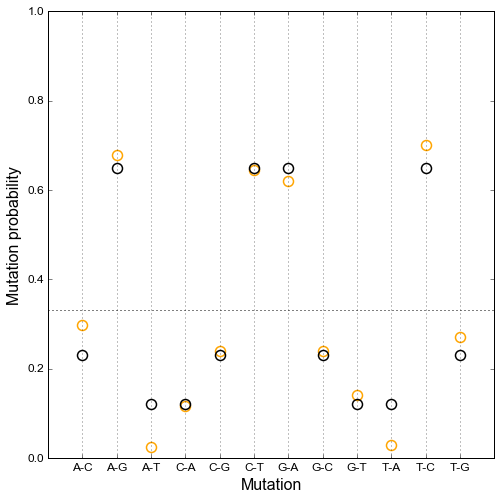

In [10]:
plt.figure('Mutation probability', figsize=(8,8))

for (x,y) in zip(['FFD_FIXED', 'MODEL'],['orange', 'black']):
    _tick_names = []
    _data = []
    for ind,base in enumerate(['A', 'C', 'G', 'T']):
        other_bases = ['A', 'C', 'G', 'T']
        other_bases.pop(ind)
        for other_base in other_bases:
            _tick_names.append('{}-{}'.format(base,other_base))
            _data.append(MUT_PROB[base][other_base][x])
    plt.plot(_data, 'o', mec=y, mfc='none', ms=10, mew=1.5, label=x)

plt.ylim(0,1)
plt.ylabel('Mutation probability', size=16)
plt.yticks(size=12)
plt.xticks(range(13), _tick_names, size=12)
plt.xlabel('Mutation', size=16)
plt.xlim(-1,12)
plt.grid(axis='x')
plt.hlines(0.33,-1,12,linestyles='dotted')

This looks remarkably good. The only real difference is the unexpectedly low probability of A<->T transversions. I don't know why this is - it may reflect some kind of codon bias? Let's just quickly check if the FFD base composition reflect that of the genome...

In [38]:
for (base,pi) in zip(['A', 'C', 'G', 'T'], [pi_a, pi_c, pi_g, pi_t]):
    given_base = np.sum(list(FFD_base[base].values()))/518
    print('{0} FFD: {1:0.1f}%, GENOME: {2:0.1f}%, RATIO: {3:0.1f}'.format(base,
                                                                          given_base*100,
                                                                          pi*100,
                                                                          given_base/pi*100))

A FFD: 16.2%, GENOME: 17.2%, RATIO: 94.3
C FFD: 34.7%, GENOME: 32.9%, RATIO: 105.7
G FFD: 35.5%, GENOME: 32.7%, RATIO: 108.5
T FFD: 13.5%, GENOME: 17.2%, RATIO: 78.6


So might be a bit biased... Let's try to check for all the fixed SYN SNPs not just FFD.

In [11]:
ALLFIX_base = {'A': {'C':0, 'G':0, 'T':0},
            'C': {'A':0, 'G':0, 'T':0},
            'G': {'A':0, 'C':0, 'T':0},
            'T': {'A':0, 'C':0, 'G':0},
            'TOTAL': 0
           }

for k,v in FIXED_ANNOTATION_DICT.items():
    #account for duplicate entries from related strains
    _v = [tuple(x) for x in v] 
    for x in set(_v): 
        #filter for synonymous
        if x[1]=='synonymous':
            wt_codon, mut_codon = x[4].split('-')
            for (W,M) in zip(wt_codon, mut_codon):
                if W!=M:
                    ALLFIX_base[W][M]+=1
                    ALLFIX_base['TOTAL']+=1
                    
ALLFIX_base

{'A': {'C': 33, 'G': 75, 'T': 2},
 'C': {'A': 32, 'G': 43, 'T': 209},
 'G': {'A': 153, 'C': 44, 'T': 26},
 'T': {'A': 2, 'C': 107, 'G': 19},
 'TOTAL': 745}

In [12]:
for base in ['A','C','G','T']:    
    c_s = np.sum(list(ALLFIX_base[base].values()))
    for x in ALLFIX_base[base]:
        print(base, '->', x, int(ALLFIX_base[base][x])/c_s)
        MUT_PROB[base][x]['ALL_FIXED'] = int(ALLFIX_base[base][x])/c_s

A -> T 0.0181818181818
A -> C 0.3
A -> G 0.681818181818
C -> A 0.112676056338
C -> T 0.735915492958
C -> G 0.151408450704
G -> A 0.686098654709
G -> T 0.116591928251
G -> C 0.19730941704
T -> A 0.015625
T -> C 0.8359375
T -> G 0.1484375


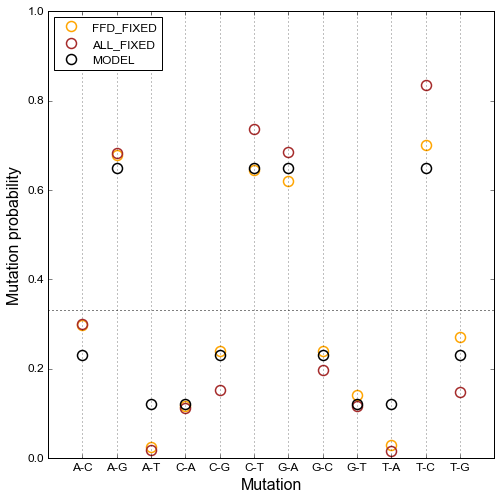

In [78]:
plt.figure('Mutation probability', figsize=(8,8))

for (x,y) in zip(['FFD_FIXED', 'ALL_FIXED', 'MODEL'],['orange', 'brown', 'black']):
    _tick_names = []
    _data = []
    for ind,base in enumerate(['A', 'C', 'G', 'T']):
        other_bases = ['A', 'C', 'G', 'T']
        other_bases.pop(ind)
        for other_base in other_bases:
            _tick_names.append('{}-{}'.format(base,other_base))
            _data.append(MUT_PROB[base][other_base][x])
    plt.plot(_data, 'o', mec=y, mfc='none', ms=10, mew=1.5, label=x)

plt.ylim(0,1)
plt.ylabel('Mutation probability', size=16)
plt.yticks(size=12)
plt.xticks(range(13), _tick_names, size=12)
plt.xlabel('Mutation', size=16)
plt.xlim(-1,12)
plt.legend(loc=2)
plt.grid(axis='x')
plt.hlines(0.33,-1,12,linestyles='dotted')

For the sake of it, check for the same in the vSNP data and add to the plot.

In [13]:
PROCESSED_PATH = '../data/processed/'

ANNOTATION_DICT = pickle.load(open('{}2_unfixed_annotation.pkl'.format(INTERIM_PATH),'rb'))
ALL = pd.read_csv('{}ALLELE_data.csv'.format(PROCESSED_PATH), index_col=0)

ALLVAR_base = {'A': {'C':0, 'G':0, 'T':0},
               'C': {'A':0, 'G':0, 'T':0},
               'G': {'A':0, 'C':0, 'T':0},
               'T': {'A':0, 'C':0, 'G':0},
               'TOTAL': 0
               }

FFDVAR_base = {'A': {'C':0, 'G':0, 'T':0},
               'C': {'A':0, 'G':0, 'T':0},
               'G': {'A':0, 'C':0, 'T':0},
               'T': {'A':0, 'C':0, 'G':0},
               'TOTAL': 0
               }

RAWVAR_base = {'A': {'C':0, 'G':0, 'T':0},
               'C': {'A':0, 'G':0, 'T':0},
               'G': {'A':0, 'C':0, 'T':0},
               'T': {'A':0, 'C':0, 'G':0},
               'TOTAL': 0
               }

for k,v in ANNOTATION_DICT.items():
    #account for duplicate entries from related strains
    _v = [tuple(x) for x in v] 
    for x in set(_v): 
        #filter for synonymous
        if x[1]=='synonymous' and int(k) in list(ALL.LOCUS):
            wt_codon, mut_codon = x[4].split('-')
            for (W,M) in zip(wt_codon, mut_codon):
                if W!=M:
                    ALLVAR_base[W][M]+=1
                    ALLVAR_base['TOTAL']+=1
            if wt_codon[:2]==mut_codon[:2]:
                try: 
                    FFDVAR_base[wt_codon[-1]][mut_codon[-1]]+=1
                    FFDVAR_base['TOTAL']+=1
                except:
                    pass
        if x[1]=='synonymous':
            wt_codon, mut_codon = x[4].split('-')
            for (W,M) in zip(wt_codon, mut_codon):
                if W!=M:
                    RAWVAR_base[W][M]+=1
                    RAWVAR_base['TOTAL']+=1
                    
FFDVAR_base

{'A': {'C': 7, 'G': 8, 'T': 0},
 'C': {'A': 2, 'G': 11, 'T': 28},
 'G': {'A': 21, 'C': 2, 'T': 3},
 'T': {'A': 1, 'C': 5, 'G': 1},
 'TOTAL': 89}

In [15]:
for base in ['A','C','G','T']:    
    c_s = np.sum(list(ALLVAR_base[base].values()))
    d_s = np.sum(list(FFDVAR_base[base].values()))
    e_s = np.sum(list(RAWVAR_base[base].values()))
    for x in ALLFIX_base[base]:
        MUT_PROB[base][x]['ALL_VAR'] = int(ALLVAR_base[base][x])/c_s
        MUT_PROB[base][x]['FFD_VAR'] = int(FFDVAR_base[base][x])/d_s
        MUT_PROB[base][x]['RAW_VAR'] = int(RAWVAR_base[base][x])/e_s

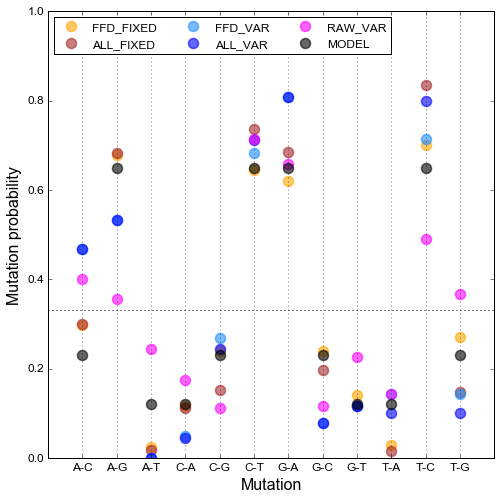

In [77]:
plt.figure('Mutation probability', figsize=(8,8))

for (x,y) in zip(['FFD_FIXED', 'ALL_FIXED', 'FFD_VAR', 'ALL_VAR', 'RAW_VAR', 'MODEL'],
                 ['orange', 'brown', 'dodgerblue', 'blue', 'magenta', 'black']):
    _tick_names = []
    _data = []
    for ind,base in enumerate(['A', 'C', 'G', 'T']):
        other_bases = ['A', 'C', 'G', 'T']
        other_bases.pop(ind)
        for other_base in other_bases:
            _tick_names.append('{}-{}'.format(base,other_base))
            _data.append(MUT_PROB[base][other_base][x])
    plt.plot(_data, 'o', mec=y, mfc=y, ms=10, mew=1.5, label=x, alpha=0.6)

plt.ylim(0,1)
plt.ylabel('Mutation probability', size=16)
plt.yticks(size=12)
plt.xticks(range(13), _tick_names, size=12)
plt.xlabel('Mutation', size=16)
plt.xlim(-1,12)
plt.legend(loc=2, ncol=3)
plt.grid(axis='x')
plt.hlines(0.33,-1,12,linestyles='dotted')

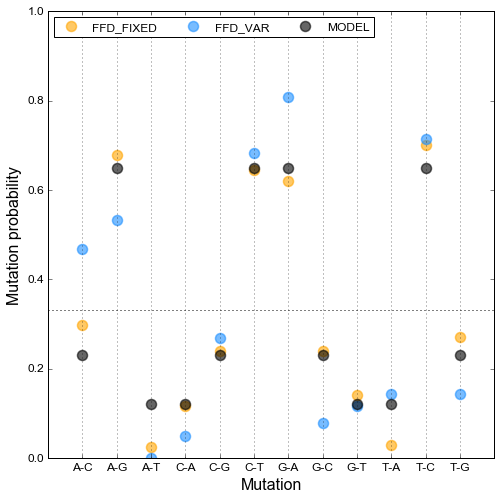

In [76]:
plt.figure('Mutation probability', figsize=(8,8))

for (x,y) in zip(['FFD_FIXED', 'FFD_VAR', 'MODEL'],
                 ['orange', 'dodgerblue', 'black']):
    _tick_names = []
    _data = []
    for ind,base in enumerate(['A', 'C', 'G', 'T']):
        other_bases = ['A', 'C', 'G', 'T']
        other_bases.pop(ind)
        for other_base in other_bases:
            _tick_names.append('{}-{}'.format(base,other_base))
            _data.append(MUT_PROB[base][other_base][x])
    plt.plot(_data, 'o', mec=y, mfc=y, ms=10, mew=1.5, label=x, alpha=0.6)

plt.ylim(0,1)
plt.ylabel('Mutation probability', size=16)
plt.yticks(size=12)
plt.xticks(range(13), _tick_names, size=12)
plt.xlabel('Mutation', size=16)
plt.xlim(-1,12)
plt.legend(loc=2, ncol=3)
plt.grid(axis='x')
plt.hlines(0.33,-1,12,linestyles='dotted')

Based on this:
- My model fits the fSNP data better than the vSNP data. Perhaps this is not surprising given that I've used fSNP data to estimate the Ti/Tv parameters.
- The bias agains the T<->A transversions is present in both vSNPs and fSNPs.
- Raw vSNPs have a very different substitution profile than anything else, suporting the amended filtering.
- The least congruent substitutions between vSNPs and fSNPs are A<->C, G<->A and C<->G. In all of these cases mutation in the right direction is more prominent in the vSNPs with the substitutions in the left direction are more prominent in the fSNPs.

The predominant mutations are clearly those driven by transitions, and this raises the possiblity that what we are looking at here are deamination events (deamination of C gives rise to U therefore leading to C->T and G->A transitions, while deamination of A gives rise to hypoxanthine which can basepair to C leading to A->G and T->C transitions). Given the defective BER in Mycobacterium it is possible that active growth correlates with the acumulation of transitions. 

Practically, which substitution matrix should I use then? The most troubling thing I have to deal with here is the T<->A transition disparity... I will stick to the estimated data.

### Empiricaly derive the expected codon substitution matrix
Start by making a mutation generator.

In [120]:
MUTATION_POOL = {'A': '',
                 'C': '',
                 'G': '',
                 'T': ''
                }

for k in MUTATION_POOL.keys():
    for k1,v1 in MUT_PROB[k].items():
        MUTATION_POOL[k]+=(k1*int(v1['FFD_FIXED']*1000))
        
MUTATION_POOL

{'A': 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTTTTTTTTTTTTTTTTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG

The null expectation of codon mutation will be estimated as follows. For each codon I will run the following simulation:
1. Randomly select a position to mutate
2. Randomly replace the base
3. Score for translational impact of the mutation. I will treat a mutation to a stop codons as a NSY substitution.

In [18]:
CODON_TABLE = {'AAA': 'K', 'AAC': 'N', 'AAG': 'K', 'AAT': 'N', 'ACA': 'T',
               'ACC': 'T', 'ACG': 'T', 'ACT': 'T', 'AGA': 'R', 'AGC': 'S', 'AGG': 'R',
               'AGT': 'S', 'ATA': 'I', 'ATC': 'I', 'ATG': 'M', 'ATT': 'I', 'CAA': 'Q',
               'CAC': 'H', 'CAG': 'Q', 'CAT': 'H', 'CCA': 'P', 'CCC': 'P', 'CCG': 'P',
               'CCT': 'P', 'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R', 'CTA': 'L',
               'CTC': 'L', 'CTG': 'L', 'CTT': 'L', 'GAA': 'E', 'GAC': 'D', 'GAG': 'E',
               'GAT': 'D', 'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A', 'GGA': 'G',
               'GGC': 'G', 'GGG': 'G', 'GGT': 'G', 'GTA': 'V', 'GTC': 'V', 'GTG': 'V',
               'GTT': 'V', 'TAA': 'STOP', 'TAC': 'Y', 'TAG': 'STOP', 'TAT': 'Y',
               'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S', 'TGA': 'STOP', 'TGC': 'C',
               'TGG': 'W', 'TGT': 'C', 'TTA': 'L', 'TTC': 'F', 'TTG': 'L', 'TTT': 'F'}

def mutate_codon(codon, mutation_pool):
    """Randomly mutate a base within a codon using
    a predefined substitution matrix. Score the 
    translational impact of mutaitons.
    
    INPUT:
    ------
    codon: str, NNN where N in ['A', 'C', 'G', 'T']
    mutation_pool: dict, key: base, value: str
    
    OUTPUT:
    ------
    int, 0|1, 0 for synonymous mutation, 1 for nonsynonymous
    
    NOTES:
    ------
    uses the standard random library
    """
    
    pos = random.randint(0,2)
    random_base = random.choice(mutation_pool[codon[pos]])
    
    cl = list(codon)
    cl[pos] = random_base
    new_codon = ''.join(cl)
    
    CODON_TABLE = {'AAA': 'K', 'AAC': 'N', 'AAG': 'K', 'AAT': 'N', 'ACA': 'T',
               'ACC': 'T', 'ACG': 'T', 'ACT': 'T', 'AGA': 'R', 'AGC': 'S', 'AGG': 'R',
               'AGT': 'S', 'ATA': 'I', 'ATC': 'I', 'ATG': 'M', 'ATT': 'I', 'CAA': 'Q',
               'CAC': 'H', 'CAG': 'Q', 'CAT': 'H', 'CCA': 'P', 'CCC': 'P', 'CCG': 'P',
               'CCT': 'P', 'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R', 'CTA': 'L',
               'CTC': 'L', 'CTG': 'L', 'CTT': 'L', 'GAA': 'E', 'GAC': 'D', 'GAG': 'E',
               'GAT': 'D', 'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A', 'GGA': 'G',
               'GGC': 'G', 'GGG': 'G', 'GGT': 'G', 'GTA': 'V', 'GTC': 'V', 'GTG': 'V',
               'GTT': 'V', 'TAA': 'STOP', 'TAC': 'Y', 'TAG': 'STOP', 'TAT': 'Y',
               'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S', 'TGA': 'STOP', 'TGC': 'C',
               'TGG': 'W', 'TGT': 'C', 'TTA': 'L', 'TTC': 'F', 'TTG': 'L', 'TTT': 'F'}
    
    return int(CODON_TABLE[codon]!=CODON_TABLE[new_codon])

In [121]:
NSY_EXPECTATION = {
    codon: np.mean([np.mean([mutate_codon(codon, MUTATION_POOL)\
                             for x in range(1000)]) for y in range(100)])
    for codon in CODON_TABLE.keys()
}

NSY_EXPECTATION

{'AAA': 0.77147999999999983,
 'AAC': 0.78310000000000002,
 'AAG': 0.79181999999999997,
 'AAT': 0.76719000000000004,
 'ACA': 0.66549999999999998,
 'ACC': 0.66368000000000005,
 'ACG': 0.66735,
 'ACT': 0.66664000000000001,
 'AGA': 0.67274,
 'AGC': 0.78346000000000005,
 'AGG': 0.69614999999999994,
 'AGT': 0.76638000000000006,
 'ATA': 0.89295999999999998,
 'ATC': 0.74596999999999991,
 'ATG': 1.0,
 'ATT': 0.75840000000000007,
 'CAA': 0.77489999999999992,
 'CAC': 0.78566999999999998,
 'CAG': 0.79521000000000019,
 'CAT': 0.76635000000000009,
 'CCA': 0.66679999999999995,
 'CCC': 0.66632000000000002,
 'CCG': 0.66755000000000009,
 'CCT': 0.66790999999999978,
 'CGA': 0.62556,
 'CGC': 0.66800999999999999,
 'CGG': 0.62692999999999999,
 'CGT': 0.66621000000000008,
 'CTA': 0.45150000000000001,
 'CTC': 0.66721999999999992,
 'CTG': 0.45156999999999997,
 'CTT': 0.66690000000000016,
 'GAA': 0.77387000000000006,
 'GAC': 0.78374999999999995,
 'GAG': 0.79522000000000004,
 'GAT': 0.76731999999999989,
 'GCA': 

In [20]:
#Save the outcome of this
pickle.dump(NSY_EXPECTATION, open('{}5_NSY_EXPECTATION.pkl'.format(INTERIM_PATH),'wb'))

Next, let's bring this together with the time points and score them.

In [122]:
ALL['CODING'] = [int(x in ['SYN', 'NSY']) for x in ALL.SNP_TYPE]

pNS_VAR = {}

click = 0
for patient in np.unique(ALL.PATIENT_ID):
    for x in [0,2,4,6,8]:
        if x in list(ALL.TIME[ALL.PATIENT_ID==patient]):
            #count observed data
            oN = Counter(ALL.SNP_TYPE[(ALL.PATIENT_ID==patient)&(ALL.TIME==x)&(ALL.CODING==1)])['NSY']
            oS = Counter(ALL.SNP_TYPE[(ALL.PATIENT_ID==patient)&(ALL.TIME==x)&(ALL.CODING==1)])['SYN']
            #use mutation matrix to derive the expectation
            eN = np.sum([NSY_EXPECTATION[x] for x in ALL.WT_CODON[
                        (ALL.PATIENT_ID==patient)&(ALL.TIME==x)&
                        (ALL.CODING==1)]])
            eS = (oN+oS)-eN
            #calculate pNS
            try:
                pNS = (oN/eN)/(oS/eS)
            
            except:
                pNS = np.nan
            
            #Remove all calculations where there were no observed mutations 
            #in either category 
            if pNS==0:
                pNS = np.nan
            if pNS==np.inf:
                pNS = np.nan
                
            #use binomial random sampling to derive a null distribution of pNS
            bN = np.sum([ss.binom(p=NSY_EXPECTATION[x],n=1).rvs(random_state=seed) for (seed,x) in enumerate(
                        ALL.WT_CODON[(ALL.PATIENT_ID==patient)&(ALL.TIME==x)&(ALL.CODING==1)])])
            bS = (oN+oS)-bN
            try:
                pNS_b = (bN/eN)/(bS/eS)
            
            except:
                pNS_b = np.nan
            
            #Remove all calculations where there were no observed mutations 
            #in either category    
            if pNS_b==0:
                pNS_b = np.nan
            if pNS_b==np.inf:
                pNS_b = np.nan
                
            

            pNS_VAR[click] = {'PATIENT_ID': patient,
                              'TIME': x,
                              'pNS': pNS, 
                              'OBSERVED_SYN': oS,
                              'OBSERVED_NSY': oN,
                              'EXPECTED_SYN': eS,
                              'EXPECTED_NSY': eN,
                              'NEUTRAL_SYN': bS,
                              'NEUTRAL_NSY': bN,
                              'pNS_NEUTRAL': pNS_b,
                              'TOTAL': oS+oN
                             }
            click+=1
            
ALL.drop('CODING', axis=1, inplace=True)

In [87]:
pNS_df = pd.DataFrame(pNS_VAR).T

pNS_df['NON_EFFICACIOUS'] = [int(x[-2:] in ['09','10', '11', '12']) for x in list(pNS_df.PATIENT_ID)]

pNS_df.head()

,EXPECTED_NSY,EXPECTED_SYN,NEUTRAL_NSY,NEUTRAL_SYN,OBSERVED_NSY,OBSERVED_SYN,PATIENT_ID,TIME,TOTAL,pNS,pNS_NEUTRAL,NON_EFFICACIOUS
0,1.45395,0.54605,2,0,2,0,Patient01,0,2,NaN,NaN,0
1,5.79964,2.20036,6,2,6,2,Patient01,2,8,1.13819,1.13819,0
2,2.91692,1.08308,4,0,3,1,Patient01,4,4,1.11393,NaN,0
3,1.45395,0.54605,2,0,2,0,Patient01,6,2,NaN,NaN,0
4,6.71774,2.28226,6,3,7,2,Patient02,0,9,1.18908,0.679473,0


MannwhitneyuResult(statistic=130.0, pvalue=0.42146244057452831)
MannwhitneyuResult(statistic=35.5, pvalue=9.459523029670376e-06)
MannwhitneyuResult(statistic=59.0, pvalue=0.00015247255002366869)


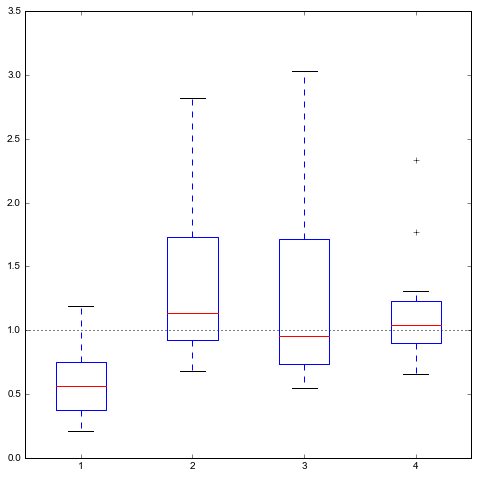

In [88]:
plt.figure('pNS boxplots', figsize=(8,8))
_NE = [list(pNS_df[x][
            (pNS_df[x]>0)&(pNS_df.NON_EFFICACIOUS==1)&
            (pNS_df.TIME!='FIXED')]) for x in ['pNS', 'pNS_NEUTRAL']]
_E = [list(pNS_df[x][
            (pNS_df[x]>0)&(pNS_df.NON_EFFICACIOUS==0)&
            (pNS_df.TIME!='FIXED')]) for x in ['pNS', 'pNS_NEUTRAL']]

plt.hlines(1,0,5,linestyles='dotted')
plt.boxplot(_E+_NE)

print(ss.mannwhitneyu(_NE[0],_NE[1]))
print(ss.mannwhitneyu(_E[0],_E[1]))
print(ss.mannwhitneyu(_E[0],_NE[0]))

vSNPs done, let's do the calculations for fSNPs.

In [56]:
FIX = pd.read_csv('{}3_FIXED_data.csv'.format(INTERIM_PATH), index_col=0)

FIX.head()

,GENE,LOCUS,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TRANSITION,WT_CODON
0,CFBS00100,18947,0,Patient01,DS,NSY,0,CCT
1,CFBS00190,37167,0,Patient01,DS,NSY,1,GGC
2,CFBS00260,52531,0,Patient01,DS,SYN,0,GGG
3,CFBS00495,99794,0,Patient01,DS,NSY,1,GCC
4,CFBS00700-CFBS00705,157894,0,Patient01,DS,IGR,1,-


In [123]:
FIX['CODING'] = [int(x in ['SYN', 'NSY']) for x in FIX.SNP_TYPE]

for patient in np.unique(FIX.PATIENT_ID):
    oN = Counter(FIX.SNP_TYPE[(FIX.PATIENT_ID==patient)&(FIX.CODING==1)])['NSY']
    oS = Counter(FIX.SNP_TYPE[(FIX.PATIENT_ID==patient)&(FIX.CODING==1)])['SYN']
    #use mutation matrix to derive the expectation
    eN = np.sum([NSY_EXPECTATION[x] for x in FIX.WT_CODON[
                (FIX.PATIENT_ID==patient)&(FIX.CODING==1)]])
    eS = (oN+oS)-eN
    #calculate pNS
    try:
        pNS = (oN/eN)/(oS/eS)

    except:
        pNS = np.nan

    #Remove all calculations where there were no observed mutations 
    #in either category 
    if pNS==0:
        pNS = np.nan
    if pNS==np.inf:
        pNS = np.nan

    #use binomial random sampling to derive a null distribution of pNS
    bN = np.sum([ss.binom(p=NSY_EXPECTATION[x],n=1).rvs(random_state=seed) for (seed,x) in enumerate(
                FIX.WT_CODON[(FIX.PATIENT_ID==patient)&(FIX.CODING==1)])])
    bS = (oN+oS)-bN
    try:
        pNS_b = (bN/eN)/(bS/eS)

    except:
        pNS_b = np.nan

    #Remove all calculations where there were no observed mutations 
    #in either category    
    if pNS_b==0:
        pNS_b = np.nan
    if pNS_b==np.inf:
        pNS_b = np.nan



    pNS_VAR[click] = {'PATIENT_ID': patient,
                      'TIME': 'FIXED',
                      'pNS': pNS, 
                      'OBSERVED_SYN': oS,
                      'OBSERVED_NSY': oN,
                      'EXPECTED_SYN': eS,
                      'EXPECTED_NSY': eN,
                      'NEUTRAL_SYN': bS,
                      'NEUTRAL_NSY': bN,
                      'pNS_NEUTRAL': pNS_b,
                      'TOTAL': oS+oN
                     }
    click+=1
            
FIX.drop('CODING', axis=1, inplace=True)

In [124]:
pNS_df = pd.DataFrame(pNS_VAR).T

pNS_df['NON_EFFICACIOUS'] = [int(x[-2:] in ['09','10', '11', '12']) for x in list(pNS_df.PATIENT_ID)]

pNS_df.head()

,EXPECTED_NSY,EXPECTED_SYN,NEUTRAL_NSY,NEUTRAL_SYN,OBSERVED_NSY,OBSERVED_SYN,PATIENT_ID,TIME,TOTAL,pNS,pNS_NEUTRAL,NON_EFFICACIOUS
0,1.45035,0.54965,2,0,2,0,Patient01,0,2,NaN,NaN,0
1,5.79568,2.20432,6,2,6,2,Patient01,2,8,1.14102,1.14102,0
2,2.91357,1.08643,4,0,3,1,Patient01,4,4,1.11866,NaN,0
3,1.45035,0.54965,2,0,2,0,Patient01,6,2,NaN,NaN,0
4,6.71372,2.28628,6,3,7,2,Patient02,0,9,1.19188,0.681077,0


MannwhitneyuResult(statistic=120.0, pvalue=0.28824253275134826)
MannwhitneyuResult(statistic=32.0, pvalue=1.1021145867119461e-05)
MannwhitneyuResult(statistic=59.0, pvalue=0.00015247255002366869)
MannwhitneyuResult(statistic=1.0, pvalue=2.3474362824769387e-05)


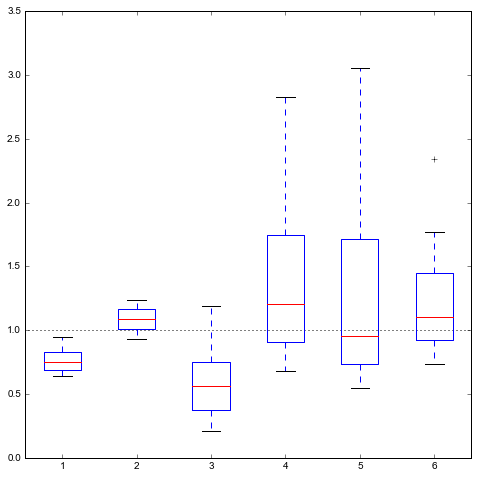

In [125]:
plt.figure('pNS boxplots', figsize=(8,8))
_NE = [list(pNS_df[x][
            (pNS_df[x]>0)&(pNS_df.NON_EFFICACIOUS==1)&
            (pNS_df.TIME!='FIXED')]) for x in ['pNS', 'pNS_NEUTRAL']]
_E = [list(pNS_df[x][
            (pNS_df[x]>0)&(pNS_df.NON_EFFICACIOUS==0)&
            (pNS_df.TIME!='FIXED')]) for x in ['pNS', 'pNS_NEUTRAL']]

_F = [list(pNS_df[x][
            (pNS_df[x]>0)&(pNS_df.TIME=='FIXED')]) for x in ['pNS', 'pNS_NEUTRAL']]

plt.hlines(1,0,7,linestyles='dotted')
plt.boxplot(_F+_E+_NE)

print(ss.mannwhitneyu(_NE[0],_NE[1]))
print(ss.mannwhitneyu(_E[0],_E[1]))
print(ss.mannwhitneyu(_E[0],_NE[0]))
print(ss.mannwhitneyu(_F[0],_F[1]))

In [127]:
pNS_df.to_csv('../data/interim/5_pNS_patients.csv')

In [3]:
pNS_df = pd.read_csv('../data/interim/5_pNS_patients.csv', index_col=0)

### Publication figure

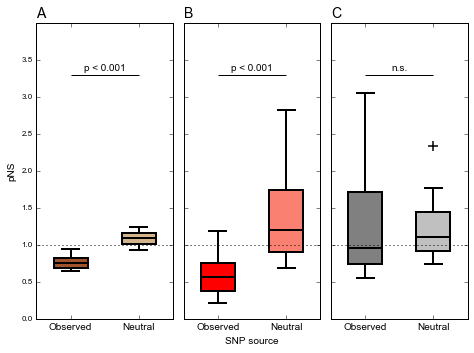

In [6]:
plt.figure('pNS_composite2', figsize=double_column_figure_r)

plt.subplot2grid((5,15), (0,0), rowspan=5, colspan=5) 
#makes a split figure - 5x15 quadrants. The first figure 
#starts in the first column of the 1st row and spans 5 rows and 5 columns.

#PLOT pNS for fSNPs
plt.hlines(1,0,3, linestyles='dotted')
bp1 = plt.boxplot([list(pNS_df.pNS[(pNS_df.TIME=='FIXED')&
                                   (pNS_df.pNS>0)]), 
                   list(pNS_df.pNS_NEUTRAL[(pNS_df.TIME=='FIXED')&
                                           (pNS_df.pNS_NEUTRAL>0)])], 
                  patch_artist=True, widths=.5)

#MODIFY THE PARAMETERS OF THE BOX PLOT
for box in bp1['boxes']:
    box.set(color='black',lw=2)

for whisker in bp1['whiskers']:
    whisker.set(color='black', linestyle='solid',lw=2)

for median in bp1['medians']:
    median.set(color='black', lw=2)
    
for cap in bp1['caps']:
    cap.set(color='black',lw=2)
    
for flier in bp1['fliers']:
    flier.set(marker='+', color='black', mew=1.5, mfc='white', ms=10)
    
fc = ['sienna', 'tan']
for ind in range(2):
    bp1['boxes'][ind].set(facecolor = fc[ind])
    
plt.ylabel('pNS', size=label_size)
plt.yticks(np.arange(0,4,.5),size=tick_size)
plt.xticks([1,2],['Observed','Neutral\n'],size=label_size)
plt.ylim(0,4)
#plt.title('All\npatients', size=16)
plt.title('A', size=14, loc='left')

plt.hlines(3.3,1,2, linestyles='solid')
plt.text(1.5,3.35,'p < 0.001', size=label_size,horizontalalignment='center')

plt.subplot2grid((5,15), (0,5), rowspan=5, colspan=5)

plt.hlines(1,0,5, linestyles='dotted')
bp2 = plt.boxplot([list(pNS_df.pNS[(pNS_df.NON_EFFICACIOUS==0)&
                                   (pNS_df.pNS>0)&(pNS_df.TIME!='FIXED')]), 
                   list(pNS_df.pNS_NEUTRAL[(pNS_df.NON_EFFICACIOUS==0)&
                                           (pNS_df.pNS_NEUTRAL>0)&
                                           (pNS_df.TIME!='FIXED')])
                  ],
                  patch_artist=True, widths=.5)

for box in bp2['boxes']:
    box.set(color='black',lw=2)

for whisker in bp2['whiskers']:
    whisker.set(color='black', linestyle='solid',lw=2)

for median in bp2['medians']:
    median.set(color='black', lw=2)
    
for cap in bp2['caps']:
    cap.set(color='black',lw=2)
    
for flier in bp2['fliers']:
    flier.set(marker='+', color='black', mew=1.5, mfc='white', ms=10)
    
fc = ['red','salmon', 'red', 'salmon']    
for ind in range(2):
    bp2['boxes'][ind].set(facecolor = fc[ind])
    

plt.xticks([1,2],['Observed','Neutral'],size=label_size)
plt.ylim(0,4)
plt.yticks(np.arange(0,4,.5), [], size=tick_size)
#plt.title('Efficacious\ntreatment', size=16)
plt.title('B', size=14, loc='left')
plt.xlabel('SNP source', size=label_size)

plt.hlines(3.3,1,2, linestyles='solid')
plt.text(1.5,3.35, 'p < 0.001', size=label_size, horizontalalignment='center')

plt.subplot2grid((5,15), (0,10), rowspan=5, colspan=5)

plt.hlines(1,0,5, linestyles='dotted')
bp3 = plt.boxplot([list(pNS_df.pNS[(pNS_df.NON_EFFICACIOUS==1)&
                                   (pNS_df.pNS>0)&
                                   (pNS_df.TIME!='FIXED')]), 
                   list(pNS_df.pNS_NEUTRAL[(pNS_df.NON_EFFICACIOUS==1)&
                                           (pNS_df.pNS_NEUTRAL>0)&
                                           (pNS_df.TIME!='FIXED')])
                   ],
                  patch_artist=True, widths=.5)

for box in bp3['boxes']:
    box.set(color='black',lw=2)

for whisker in bp3['whiskers']:
    whisker.set(color='black', linestyle='solid',lw=2)

for median in bp3['medians']:
    median.set(color='black', lw=2)
    
for cap in bp3['caps']:
    cap.set(color='black',lw=2)
    
for flier in bp3['fliers']:
    flier.set(marker='+', color='black', mew=1.5, mfc='white', ms=10)
    
fc = ['grey','silver','grey', 'silver']
for ind in range(2):
    bp3['boxes'][ind].set(facecolor = fc[ind])
    

plt.xticks([1,2],['Observed','Neutral'],size=label_size)
plt.ylim(0,4)
plt.yticks(np.arange(0,4,.5), [], size=tick_size)
#plt.title('Non-efficacious\ntreatment', size=16)
plt.title('C', size=14, loc='left')

plt.hlines(3.3,1,2, linestyles='solid')
#plt.text(1.5,3.35, 'p = 0.42', size=16,horizontalalignment='center')
plt.text(1.5,3.35, 'n.s.', size=label_size ,horizontalalignment='center')

#plt.subplots_adjust(bottom=0.2)
plt.tight_layout()

plt.savefig('../reports/figures/5_pNS.pdf')
#plt.savefig('../reports/figures/5_pNS.png',dpi=300)

## Conclusion
Based on these findings we can conlcude that efficaciously treated patients indeed have a much lower pNS than would be expected under the assumption of neutrality - as suggested by MC modelling. This echoes the expected outcome for fSNPs (expectations based on published results). This is not the case for ineffectively treated patients.